In [53]:
import pandas as pd
import numpy as np
import pycountry
import re
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import country_converter as coco
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


## Clean and prepare the data

In [120]:
data=pd.read_csv('un_general_debates_extended.csv', index_col=0)


In [4]:
'''
data=pd.read_csv('un-general-debates.csv')

# we add a column for the country 
cc = coco.CountryConverter()

# we get rid of EU because it isnt a countr
data = data[data['country'] != 'EU']

country_raw = data['country']

# list of conversion former country => new country
former_country_new={'YDYE':'YEM', 'CSK':'CZE', 'YUG':'SRB', 'DDR':'DE'}
some_names = country_raw.map(former_country_new).fillna(country_raw)
country_name_short = cc.convert(names = some_names, to = 'name_short')

data.loc[:,'country_name_short']=country_name_short'''

/tmp/ipykernel_16928/43217091.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'country_name_short']=country_name_short


,session,year,country,text,country_name_short
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,Maldives
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",Finland
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",Niger
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,Uruguay
4,44,1989,ZWE,﻿I should like at the outset to express my del...,Zimbabwe
...,...,...,...,...,...
7502,56,2001,KAZ,﻿This session\nthat is taking place under extr...,Kazakhstan
7503,56,2001,LBR,﻿I am honoured to\nparticipate in this histori...,Liberia
7504,56,2001,BDI,﻿It\nis for me a signal honour to take the flo...,Burundi
7505,56,2001,HUN,"﻿First, may I congratulate Mr. Han Seung-soo o...",Hungary


In [121]:
cc = coco.CountryConverter()
country_name_short=data['country_name_short']
un_region_names = cc.convert(names = country_name_short, to = 'UNregion')

data.loc[:,'UN_region']=un_region_names
data

,country,text,year,country_name_short,UN_region
0,CHL,I shall occupy this rostrum for a few minutes ...,1946,Chile,South America
1,COL,The Colombian delegation does not consider it ...,1946,Colombia,South America
2,BLR,As more than a year has elapsed since the Unit...,1946,Belarus,Eastern Europe
3,IND,I stand before this great Assembly — unique in...,1946,India,Southern Asia
4,GBR,"In his great pronouncement here the other day,...",1946,United Kingdom,Northern Europe
...,...,...,...,...,...
10563,GAB,"It is my pleasant duty to offer you, Mr. Presi...",1963,Gabon,Middle Africa
10564,TCD,"It Is not without a certain pride, mixed with ...",1963,Chad,Middle Africa
10565,COL,"Colombia, and the delegation which represents ...",1963,Colombia,South America
10566,TUN,"Mr. President, it is a pleasure for me first o...",1963,Tunisia,Northern Africa


In [122]:
# convert text data to lower case (for easier analysis)
data.loc[:,'text'] = data['text'].str.lower()
# Remove unusual symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    # Remove things between brackets
    cleaned = re.sub("\[.*?\]", " ", cleaned)

    return cleaned.strip()

# clean text
data.loc[:,'text'] = data.text.apply(lambda x: clean(x))

In [57]:
# remove data with null value in year column
data = data[data['year'].notnull()]

# # drop session column -- provides no information
# data = data.drop(['session'], axis=1)

In [58]:
from nltk.tokenize import ToktokTokenizer
import string
from sklearn.feature_extraction import text
from functools import reduce
import pandas as pd
import unicodedata
import sys

#====================================================================================#
#
# Description:
# A script to preprocess political texts, with procedural stop word removal.
# For more information, see www.github.com/lrheault/partyembed
#
# Usage:
# python3 preprocess.py [USA/Canada/UK]
#
# @author: L. Rheault
#
#====================================================================================#


tk = ToktokTokenizer()
# For replacement of contractions.
contractions = {"you'd": 'you would', "he'd": 'he would', "she's": 'she is', "where'd": 'where did', "might've": 'might have', "he'll": 'he will', "they'll": 'they will',  "mightn't": 'might not', "you'd've": 'you would have', "shan't": 'shall not', "it'll": 'it will', "mayn't": 'may not', "couldn't": 'could not', "they'd": 'they would', "so've": 'so have', "needn't've": 'need not have', "they'll've": 'they will have', "it's": 'it is', "haven't": 'have not', "didn't": 'did not', "y'all'd": 'you all would', "needn't": 'need not', "who'll": 'who will', "wouldn't've": 'would not have', "when's": 'when is', "will've": 'will have', "it'd've": 'it would have', "what'll": 'what will', "that'd've": 'that would have', "y'all're": 'you all are', "let's": 'let us', "where've": 'where have', "o'clock": 'oclock', "when've": 'when have', "what're": 'what are', "should've": 'should have', "you've": 'you have', "they're": 'they are', "aren't": 'are not', "they've": 'they have', "it'd": 'it would', "i'll've": 'i will have', "they'd've": 'they would have', "you'll've": 'you will have', "wouldn't": 'would not', "we'd": 'we would', "hadn't've": 'had not have', "weren't": 'were not', "i'd": 'i would', "must've": 'must have', "what's": 'what is', "mustn't've": 'must not have', "what'll've": 'what will have', "ain't": 'aint', "doesn't": 'does not', "we'll": 'we will', "i'd've": 'i would have', "we've": 'we have', "oughtn't": 'ought not', "you're": 'you are', "who'll've": 'who will have', "shouldn't": 'should not', "can't've": 'cannot have', "i've": 'i have', "couldn't've": 'could not have', "why've": 'why have', "what've": 'what have', "can't": 'cannot', "don't": 'do not', "that'd": 'that would', "who's": 'who is', "would've": 'would have', "there'd": 'there would', "shouldn't've": 'should not have', "y'all": 'you all', "mustn't": 'must not', "she'll": 'she will', "hadn't": 'had not', "won't've": 'will not have', "why's": 'why is', "'cause": 'because', "wasn't": 'was not', "shan't've": 'shall not have', "ma'am": 'madam', "hasn't": 'has not', "to've": 'to have', "how'll": 'how will', "oughtn't've": 'ought not have', "he'll've": 'he will have', "we'd've": 'we would have', "won't": 'will not', "could've": 'could have', "isn't": 'is not', "she'll've": 'she will have', "we'll've": 'we will have', "you'll": 'you will', "who've": 'who have', "there's": 'there is', "y'all've": 'you all have', "we're": 'we are', "i'll": 'i will', "i'm": 'i am', "how's": 'how is', "she'd've": 'she would have', "sha'n't": 'shall not', "there'd've": 'there would have', "he's": 'he is', "it'll've": 'it will have', "that's": 'that is', "y'all'd've": 'you all would have', "he'd've": 'he would have', "how'd": 'how did', "where's": 'where is', "so's": 'so as', "she'd": 'she would', "mightn't've": 'might not have'}


In [59]:
un_stopwords = ['nations','year','believe','important','assembly','secretary',
                'conference', 'like', 'way', 'state', 'resolution', 
                'government', 'make', 'role', 
                'united nation', 'united nations', 'general assembly', 'republic of', 'secretary general', 'the world', 
                'ibid', 'security council', 'member state', 'country', 'must', 'many'] + list(text.ENGLISH_STOP_WORDS)

def tokenize_text(text, stopwords=un_stopwords):
    text = reduce(lambda a, kv: a.replace(*kv), contractions.items(), text.lower())
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    tokens = tk.tokenize(text)
    
    tokens = [token for token in tokens if len(token) > 3 and
             token not in stopwords and not token.isdigit()]
    
    #remove inflectional endings and get the root word (lemma):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmas

data['clean_text'] = data['text'].apply(tokenize_text)


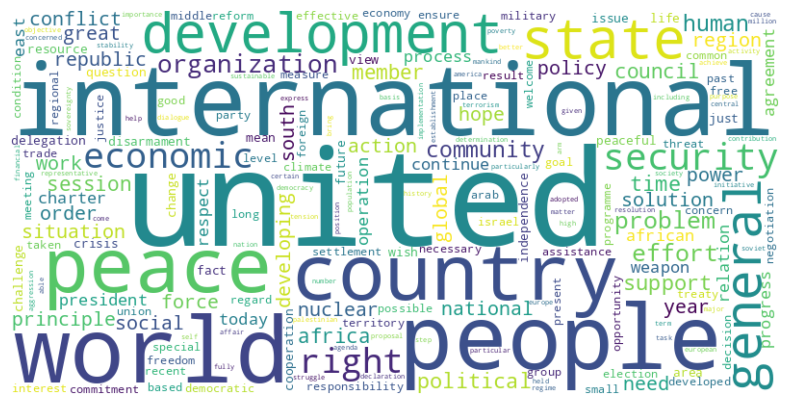

In [60]:
# Combine all the text from the 'text' column into a single string
text_combined = ' '.join(data['clean_text'].apply(lambda x: ' '.join(x)))

# Generate word frequencies
word_freq = pd.Series(text_combined.split()).value_counts()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
def create_tag(row):
    country= row["UN_region"].replace(' ', '_')
    return country + "_" + str(row["year"])

data["tag"] = data.apply(lambda row: create_tag(row), axis=1)

In [62]:
grouped_df=data.groupby('tag')['clean_text'].apply(sum).reset_index()
dict_tag_grouped_text = dict(zip(grouped_df['tag'], grouped_df['clean_text']))
data.loc[:,'clean_text_merged'] = data['tag'].map(lambda x: dict_tag_grouped_text.get(x, None))
data=data[['year', 'clean_text', 'tag', 'UN_region', 'clean_text_merged']]
data.drop_duplicates(subset=['tag'], keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)
data

/tmp/ipykernel_16928/3780286785.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  grouped_df=data.groupby('tag')['clean_text'].apply(sum).reset_index()


,year,clean_text,tag,UN_region,clean_text_merged
0,1946,"[shall, occupy, rostrum, minute, order, genera...",South_America_1946,South America,"[shall, occupy, rostrum, minute, order, genera..."
1,1946,"[elapsed, united, charter, signed, francisco, ...",Eastern_Europe_1946,Eastern Europe,"[elapsed, united, charter, signed, francisco, ..."
2,1946,"[stand, great, unique, annals, human, history,...",Southern_Asia_1946,Southern Asia,"[stand, great, unique, annals, human, history,..."
3,1946,"[great, pronouncement, president, truman, used...",Northern_Europe_1946,Northern Europe,"[great, pronouncement, president, truman, used..."
4,1946,"[presence, york, affords, objective, proof, co...",Central_America_1946,Central America,"[presence, york, affords, objective, proof, co..."
...,...,...,...,...,...
1513,1963,"[president, eighteenth, session, general, dist...",Western_Europe_1963,Western Europe,"[president, eighteenth, session, general, dist..."
1514,1963,"[president, selection, task, presiding, eighte...",Central_America_1963,Central America,"[president, selection, task, presiding, eighte..."
1515,1963,"[wish, extend, president, warm, congratulation...",Northern_Europe_1963,Northern Europe,"[wish, extend, president, warm, congratulation..."
1516,1963,"[fact, emerged, clearly, general, debate, fear...",Southern_Africa_1963,Southern Africa,"[fact, emerged, clearly, general, debate, fear..."


In [63]:
from collections import Counter

# Count the occurrences of each word in the entire corpus
word_counts = Counter(word for text_list in data['clean_text'] for word in text_list)

# Filter out words that appear less than three times
words_to_keep = {word for word, count in word_counts.items() if count >= 3}

# Remove the filtered words from the DataFrame
def filter_words(text_list):
    return [word for word in text_list if word in words_to_keep]

# Apply the filter_words function to each row of the 'text' column
data['clean_text'] = data['clean_text'].apply(filter_words)


In [64]:
documents = [TaggedDocument(data['clean_text'].iloc[k], [data['tag'].iloc[k]]) for k in tqdm(range(len(data)))]

model = Doc2Vec(documents, workers=10, vector_size=300, min_count=10, window=10, epochs=5)
fname = f"doc2vec_un_region"
model.save(fname)
model = Doc2Vec.load(fname)

100%|██████████| 1518/1518 [00:00<00:00, 55329.69it/s]


In [65]:
data_embed = data[['tag']].drop_duplicates()
data_embed[f'text_embedding'] = data_embed['tag'].progress_apply(lambda x: model.dv[x])
data_embed['year']=data['year']
data_embed['clean_text']=data['clean_text']
data_embed['UN_region']=data['UN_region']
data_embed.to_csv(f'df_text_embedding_un_region.csv')

100%|██████████| 1518/1518 [00:00<00:00, 584553.20it/s]


In [66]:
data_embed=pd.read_csv('df_text_embedding_un_region.csv', index_col=0)
def add_comas(row):
    string_representation=row['text_embedding']
    string_without_whitespace = '['+string_representation[2:]
    string_with_commas = ', '.join(string_without_whitespace.split())
    return string_with_commas 

data_embed['text_embedding']= data_embed.apply(lambda row: add_comas(row), axis=1)
data_embed['text_embedding'] = data_embed['text_embedding'].apply(ast.literal_eval)
data_embed ['clean_text'] = data_embed['clean_text'].apply(ast.literal_eval)


In [67]:
data_embed

,tag,text_embedding,year,clean_text,UN_region
0,South_America_1946,"[0.118095383, 0.143396959, 0.0681748912, 0.078...",1946,"[shall, occupy, rostrum, minute, order, genera...",South America
1,Eastern_Europe_1946,"[0.0468178652, -0.0569506735, 0.105229862, 0.0...",1946,"[elapsed, united, charter, signed, francisco, ...",Eastern Europe
2,Southern_Asia_1946,"[0.02195002, 0.1232589, 0.01689953, 0.12130769...",1946,"[stand, great, unique, annals, human, history,...",Southern Asia
3,Northern_Europe_1946,"[0.27592787, -0.11463541, -0.32258075, -0.0974...",1946,"[great, pronouncement, president, truman, used...",Northern Europe
4,Central_America_1946,"[0.12628756, 0.23712905, 0.12079078, -0.026394...",1946,"[presence, york, affords, objective, proof, co...",Central America
...,...,...,...,...,...
1513,Western_Europe_1963,"[0.14252752, 0.07695942, -0.02090806, -0.13186...",1963,"[president, eighteenth, session, general, dist...",Western Europe
1514,Central_America_1963,"[0.17926772, 0.16453837, 0.13165365, 0.2207703...",1963,"[president, selection, task, presiding, eighte...",Central America
1515,Northern_Europe_1963,"[0.08031124, 0.20564528, 0.19366023, 0.0294820...",1963,"[wish, extend, president, warm, congratulation...",Northern Europe
1516,Southern_Africa_1963,"[0.0596674, 0.21511754, -0.05496796, -0.406371...",1963,"[fact, emerged, clearly, general, debate, fear...",Southern Africa


In [68]:
REGION_COL = {
    'Australia and New Zealand': 'blue',
    'Caribbean': 'green',
    'Central America': 'red',
    'Central Asia': 'orange',
    'Eastern Africa': 'purple',
    'Eastern Asia': 'cyan',
    'Eastern Europe': 'magenta',
    'Melanesia': 'yellow',
    'Micronesia': 'lime',
    'Middle Africa': 'pink',
    'Northern Africa': 'brown',
    'Northern America': 'teal',
    'Northern Europe': 'olive',
    'Polynesia': 'navy',
    'South America': 'maroon',
    'South-eastern Asia': 'indigo',
    'Southern Africa': 'gold',
    'Southern Asia': 'tan',
    'Southern Europe': 'skyblue',
    'Western Africa': 'violet',
    'Western Asia': 'crimson',
    'Western Europe': 'salmon'
}


## Unguided analysis (PCA)

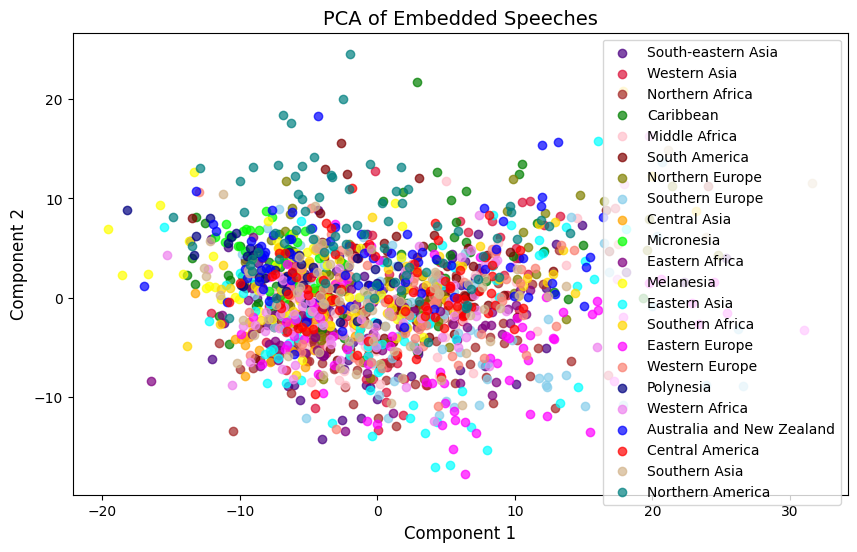

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Function to perform PCA
def perform_pca(df):
    # Convert the embeddings to a numpy array
    X = np.array(df['text_embedding'].tolist())
    
    # Standardize the data
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca

# Perform PCA on df_main
pca_main, X_pca_main = perform_pca(data_embed)

def project_pca(df_subset):
    # X should be a numpy array of shape (n_samples, n_features)
    X_subset = np.array(df_subset['text_embedding'].tolist())
    
    # Step 2: Standardize the data
    X_scaled_subset = scaler.transform(X_subset)
    X_pca_subset = pca_main.transform(X_scaled_subset)

    return X_pca_subset

# Parcourir les familles et créer un graphique en nuage de points pour chaque famille
for un_region in set(data_embed['UN_region'].values):
    # Filtrer les données pour la famille actuelle
    data = data_embed.loc[data_embed['UN_region']==un_region].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la region actuelle
    projections_2D = project_pca(data)
    
    # Créer un graphique en nuage de points pour la region actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=un_region, color=REGION_COL[un_region])

ax.set_title('PCA of Embedded Speeches', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)

# Ajouter une légende
ax.legend()
plt.savefig('PCA_data_by_region.png')
# Afficher le graphique
plt.show()


In [70]:
# Calculate the mean values of component 1 and component 2
mean_component1 = np.mean(X_pca_main[:, 0])
mean_component2 = np.mean(X_pca_main[:, 1])

# Identify the indices of data points in the bottom left quadrant
bottom_left_indices = np.where((X_pca_main[:, 0] < mean_component1) & (X_pca_main[:, 1] < mean_component2))[0]

# Retrieve the corresponding words from df_main based on the indices
words_bottom_left = data_embed.iloc[bottom_left_indices]['clean_text'].values

flattened_words_bottom_left = [word for sublist in words_bottom_left for word in sublist]
words_bottom_left=list(set(flattened_words_bottom_left))

# Sort these words based on their distance from the bottom left in the PCA plot
min_component1 = np.min(X_pca_main[:, 0])
min_component2 = np.min(X_pca_main[:, 1])

bottom_left_point = (min_component1, min_component2)

distances_from_bottom_left = np.sqrt((X_pca_main[:, 0] - bottom_left_point[0])**2 + (X_pca_main[:, 1] - bottom_left_point[1])**2)

# Sort the words based on their distances from the origin
sorted_words_bottom_left = [word for _, word in sorted(zip(distances_from_bottom_left[bottom_left_indices], words_bottom_left))]

In [71]:
# Identify the indices of data points in the top left quadrant
top_left_indices = np.where((X_pca_main[:, 0] < mean_component1) & (X_pca_main[:, 1] > mean_component2))[0]

# Retrieve the corresponding words from df_main based on the indices
words_top_left = data_embed.iloc[top_left_indices]['clean_text'].values
# Flatten the list of lists
flattened_words_top_left = [word for sublist in words_top_left for word in sublist]

# Get unique words
words_top_left = list(set(flattened_words_top_left))

# Sort these words based on their distance from the top left in the PCA plot
min_component1 = np.min(X_pca_main[:, 0])
max_component2 = np.min(X_pca_main[:, 1])

top_left_point = (min_component1, max_component2)

distances_from_top_left = np.sqrt((X_pca_main[:, 0] - top_left_point[0])**2 + (X_pca_main[:, 1] - top_left_point[1])**2)

# Sort the words based on their distances from the origin
sorted_words_top_left = [word for _, word in sorted(zip(distances_from_top_left[top_left_indices], words_top_left))]

In [72]:
# Identify the indices of data points in the top right quadrant
top_right_indices = np.where((X_pca_main[:, 0] > mean_component1) & (X_pca_main[:, 1] > mean_component2))[0]

# Retrieve the corresponding words from df_main based on the indices
words_top_right = data_embed.iloc[top_right_indices]['clean_text'].values

# Flatten the list of lists
flattened_words_top_right = [word for sublist in words_top_right for word in sublist]

# Get unique words
words_top_right = list(set(flattened_words_top_right))

# Sort these words based on their distance from the top right in the PCA plot
max_component1 = np.max(X_pca_main[:, 0])
max_component2 = np.max(X_pca_main[:, 1])

top_right_point = (max_component1, max_component2)

distances_from_top_right = np.sqrt((X_pca_main[:, 0] - top_right_point[0])**2 + (X_pca_main[:, 1] - top_right_point[1])**2)

# Sort the words based on their distances from the origin
sorted_words_top_right = [word for _, word in sorted(zip(distances_from_top_right[top_right_indices], words_top_right))]

In [73]:
# Identify the indices of data points in the bottom right quadrant
bottom_right_indices = np.where((X_pca_main[:, 0] > mean_component1) & (X_pca_main[:, 1] < mean_component2))[0]

# Retrieve the corresponding words from df_main based on the indices
words_bottom_right = data_embed.iloc[bottom_right_indices]['clean_text'].values

# Flatten the list of lists
flattened_words_bottom_right = [word for sublist in words_bottom_right for word in sublist]

# Get unique words
words_bottom_right = list(set(flattened_words_bottom_right))

# Sort these words based on their distance from the bottom right in the PCA plot
max_component1 = np.max(X_pca_main[:, 0])
min_component2 = np.min(X_pca_main[:, 1])

bottom_right_point = (max_component1, min_component2)

distances_from_bottom_right = np.sqrt((X_pca_main[:, 0] - bottom_right_point[0])**2 + (X_pca_main[:, 1] - bottom_right_point[1])**2)

# Sort the words based on their distances from the origin
sorted_words_bottom_right = [word for _, word in sorted(zip(distances_from_bottom_right[bottom_right_indices], words_bottom_right))]

In [74]:
# now print the words defining the axes
print("Words closest to the bottom left quadrant of PCA plot:", sorted_words_bottom_left[:5])
print("Words closest to the bottom right quadrant of PCA plot:", sorted_words_bottom_right[:5])
print("Words closest to the top right quadrant of PCA plot:", sorted_words_top_right[:5])
print("Words closest to the top left quadrant of PCA plot:", sorted_words_top_left[:5])


Words closest to the bottom left quadrant of PCA plot: ['cooperation', 'transcending', 'prefer', 'wielding', 'facilitating']
Words closest to the bottom right quadrant of PCA plot: ['obliterate', 'helpless', 'decision', 'propagate', 'exciting']
Words closest to the top right quadrant of PCA plot: ['proposal', 'fascist', 'ignite', 'commodity', 'showdown']
Words closest to the top left quadrant of PCA plot: ['sidetracked', 'cooperation', 'exemplary', 'north', 'warns']


## Guided analysis

In [75]:
tokenized_corpus = data_embed['clean_text'].values

# Seed words

territorial_terms = ['bloc', 'region', 'civilisation', 'country', 'nation']
functional_terms = ['class', 'ideology', 'inequality', 'group', 'social']

seed_words = territorial_terms + functional_terms

# Calculate average vector for seed words
territorial_seed_vectors = sum([model.wv[word] for word in territorial_terms if word in model.wv.index_to_key]) / len(territorial_terms)
functional_seed_vectors = sum([model.wv[word] for word in functional_terms if word in model.wv.index_to_key]) / len(functional_terms)

In [76]:
# Calculate semantic similarity between each word in the vocabulary and seed words
word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
word_similarities = {}

for word, vector in word_vectors.items():
    territorial_similarity = cosine_similarity([vector], [territorial_seed_vectors])[0][0]
    functional_similarity = cosine_similarity([vector], [functional_seed_vectors])[0][0]
    word_similarities[word] = (territorial_similarity, functional_similarity)

# Sort words by functional similarity
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: x[1], reverse=True)


In [91]:
def cosine_similarity_row(row, ref_vector):
    words = [word for word in row if word in model.wv.index_to_key]
    ref_vector_similarity_row=[]
    for i in range(len(words)):
        word_i=words[i]
        vector=model.wv[word_i]
        ref_vector_similarity = cosine_similarity([vector], [ref_vector])[0][0]
        ref_vector_similarity_row.append(ref_vector_similarity)
    similarity=sum(ref_vector_similarity_row)/len(ref_vector_similarity_row)
    return similarity

In [93]:
# Calculate cosine similarity between average embeddings and all embedded speeches

data_embed['territorial_similarity'] = data_embed['clean_text'].apply(lambda x: cosine_similarity_row(x, territorial_seed_vectors))
data_embed['functional_similarity'] = data_embed['clean_text'].apply(lambda x: cosine_similarity_row(x, functional_seed_vectors))

In [118]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][0]), reverse=True)
top_20_words_territorial = sorted_word_similarities[:20]
flop_20_words_territorial = sorted_word_similarities[-20:]

high_terr_low_func = sorted(top_20_words_territorial, key=lambda x: (x[1][1]), reverse=True)
high_terr_low_func_words = [word for word, (func_sim, terr_sim) in high_terr_low_func[:10]]
high_terr_high_func_words = [word for word, (func_sim, terr_sim) in high_terr_low_func[-10:]]
low_terr_low_func = sorted(flop_20_words_territorial, key=lambda x: (x[1][1]), reverse=True)
low_terr_low_func_words = [word for word, (func_sim, terr_sim) in low_terr_low_func[:10]]
low_terr_high_func_words = [word for word, (func_sim, terr_sim) in low_terr_low_func[-10:]]

print("Top 10 words related to high functional terms and high territorial terms:", high_terr_high_func_words)
print("Top 10 words related to low functional terms and high territorial terms:", high_terr_low_func_words)
print("Top 10 words related to low functional terms and low territorial terms:", low_terr_low_func_words)
print("Top 10 words related to high functional terms and low territorial terms:", low_terr_high_func_words)


Top 10 words related to high functional terms and high territorial terms: ['alliance', 'separating', 'hemisphere', 'moderating', 'oceania', 'country', 'mediterranean', 'situated', 'neighbor', 'neighbour']
Top 10 words related to low functional terms and high territorial terms: ['homogeneous', 'hegemony', 'exerts', 'detriment', 'historically', 'traditionally', 'grouping', 'location', 'bloc', 'superpower']
Top 10 words related to low functional terms and low territorial terms: ['care', 'punishment', 'health', 'penalty', 'prosecutor', 'fitting', 'ritual', 'eagerly', 'fiftieth', 'boutros']
Top 10 words related to high functional terms and low territorial terms: ['guidance', 'ghali', 'timely', 'kofi', 'xxiii', 'perez', 'encyclical', 'annan', 'record', 'moon']


In [119]:
sorted_word_similarities = sorted(word_similarities.items(), key=lambda x: (x[1][1]), reverse=True)
top_20_words_functional = sorted_word_similarities[:20]
flop_20_words_functional = sorted_word_similarities[-20:]

high_func_low_terr = sorted(top_20_words_functional, key=lambda x: (x[1][1]), reverse=True)
high_func_low_terr_words = [word for word, (func_sim, terr_sim) in high_func_low_terr[:10]]
high_func_high_terr_words = [word for word, (func_sim, terr_sim) in high_func_low_terr[-10:]]
low_func_low_terr = sorted(flop_20_words_functional, key=lambda x: (x[1][1]), reverse=True)
low_func_low_terr_words = [word for word, (func_sim, terr_sim) in low_func_low_terr[:10]]
low_func_high_terr_words = [word for word, (func_sim, terr_sim) in low_func_low_terr[-10:]]

print("Top 10 words related to high functional terms and high territorial terms:", high_func_high_terr_words)
print("Top 10 words related to high functional terms and low territorial terms:", high_func_low_terr_words)
print("Top 10 words related to low functional terms and low territorial terms:", low_func_low_terr_words)
print("Top 10 words related to low functional terms and high territorial terms:", low_func_high_terr_words)


Top 10 words related to high functional terms and high territorial terms: ['regardless', 'hinders', 'markedly', 'ideological', 'pseudo', 'combination', 'philosophical', 'irrespective', 'ethnicity', 'backwardness']
Top 10 words related to high functional terms and low territorial terms: ['social', 'socio', 'linguistic', 'fragmentation', 'misinformation', 'differing', 'ideology', 'basically', 'inequality', 'politico']
Top 10 words related to low functional terms and low territorial terms: ['suspension', 'moon', 'japan', 'conclusion', 'ratify', 'welcomed', 'underlined', 'kingdom', 'announcement', 'netherlands']
Top 10 words related to low functional terms and high territorial terms: ['date', 'moratorium', 'jarring', 'indonesia', 'resumed', 'conclude', 'signature', 'announce', 'assurance', 'test']


## Guided projections according to the git

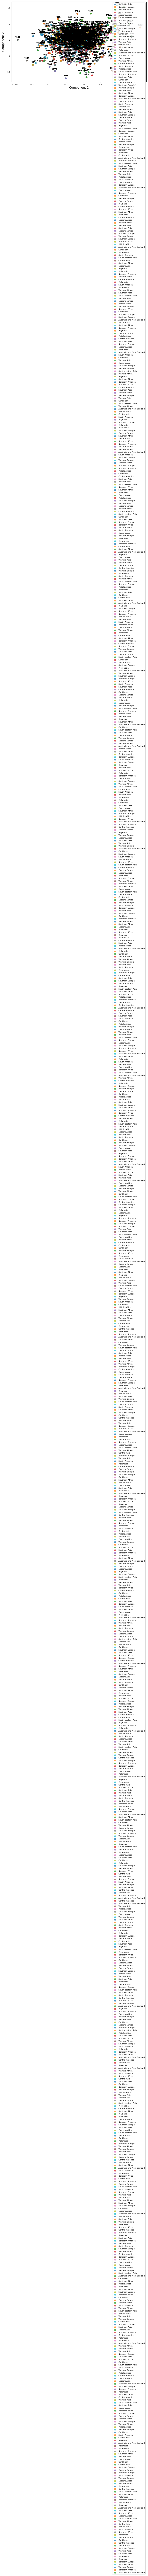

In [100]:
families = data['UN_region'].values

# Définir la taille de la police de caractère
plt.rcParams.update({'font.size': 8})

# Trier les données par année
df_sorted = data_embed.sort_values(by=['year'])

# Définir la taille du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les familles et créer un graphique en nuage de points pour chaque famille
for family in families:
    # Filtrer les données pour la famille actuelle
    data_region = df_sorted.loc[df_sorted['UN_region']==family].reset_index()
    
    # Obtenir les projections 2D pour les embeddings de la famille actuelle
    projections_2D = custom_projection_2D(data_region[f'text_embedding'], model)
    
    # Créer un graphique en nuage de points pour la famille actuelle
    ax.scatter(projections_2D[:,0], projections_2D[:,1], alpha=0.7, label=family)
    
    # Ajouter l'année sur chaque point, avec une barre de séparation en cas de chevauchement
    for i, year in enumerate(data_region['year']):
        # Vérifier s'il y a un chevauchement avec l'année précédente
        if i > 0 and data_region['year'][i-1] == year:
            # Ajouter une barre de séparation
            ax.plot([projections_2D[i-1,0], projections_2D[i,0]], [projections_2D[i-1,1], projections_2D[i,1]], color=REGION_COL[family], linestyle='-', linewidth=0.5)
            # Ajouter l'année avec une légère décalage vertical
            ax.text(projections_2D[i,0], projections_2D[i,1]+0.8, year, ha='center', va='bottom')
        else:
            # Ajouter l'année sans barre de séparation
            ax.text(projections_2D[i,0], projections_2D[i,1]+0.5, year, ha='center', va='bottom')

    
# Ajouter un titre et des labels d'axes
# Définir la taille de la police de caractère pour le titre du graphique

#ax.set_title('Party Placement in the European Parliament (1999-2022)', fontsize=14)

# Définir la taille de la police de caractère pour les étiquettes d'axes
ax.set_xlabel('Component 1', fontsize=12)
ax.set_ylabel('Component 2', fontsize=12)


# Ajouter une légen



# Ajouter une légende
ax.legend()
plt.savefig('PCA_R_L_FR.png')
# Afficher le graphique
plt.show()


In [1]:
model.most_similar('tree')

NameError: name 'model' is not defined